In [2]:
import time
print 'author: zhaoke'
print time.ctime()

author: zhaoke
Fri Jun 30 02:05:18 2017


# 检查spark环境是否成功建立

In [3]:
sc

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入必要的库

In [6]:
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *
import distkeras.utils
from distkeras.job_deployment import Job

设置端口

In [7]:
addition = 0
master_port = 5000
send_port = 8000
master_port += addition
send_port += addition
print master_port
print send_port

5000
8000


# 定义CTC Loss

In [9]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# 构造CTC模型，生成训练器

In [22]:
num_executors = 1
num_cores = 1
num_workers = num_executors * num_cores
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghijlmnqrtuwxy"
width, height, n_len, n_class = 140, 44, 6, len(chars)+1

rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru1_b')(x)
gru1_merged = merge([gru_1, gru_1b], mode='sum')

from keras

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru2_b')(gru1_merged)
x = merge([gru_2, gru_2b], mode='concat')
x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

model.save('/home/ubuntu/models/rawmodel.h5')

from distkeras.job_deployment import graph
graph.append(tf.get_default_graph())

trainer = AEASGD(keras_model=model, worker_optimizer=optimizer, loss={'ctc': lambda y_true, y_pred: y_pred}, num_workers=num_workers, 
                 batch_size=32, features_col="features_normalized", label_col="newlabel", num_epoch=1,
                 communication_window=32, rho=5.0, learning_rate=0.1, master_port=master_port)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, kernel_initializer="he_normal", name="gru1")`
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, go_backwards=True, kernel_initializer="he_normal", name="gru1_b", return_sequences=True)`


AttributeError: 'function' object has no attribute 'add'

# 网络结构可视化

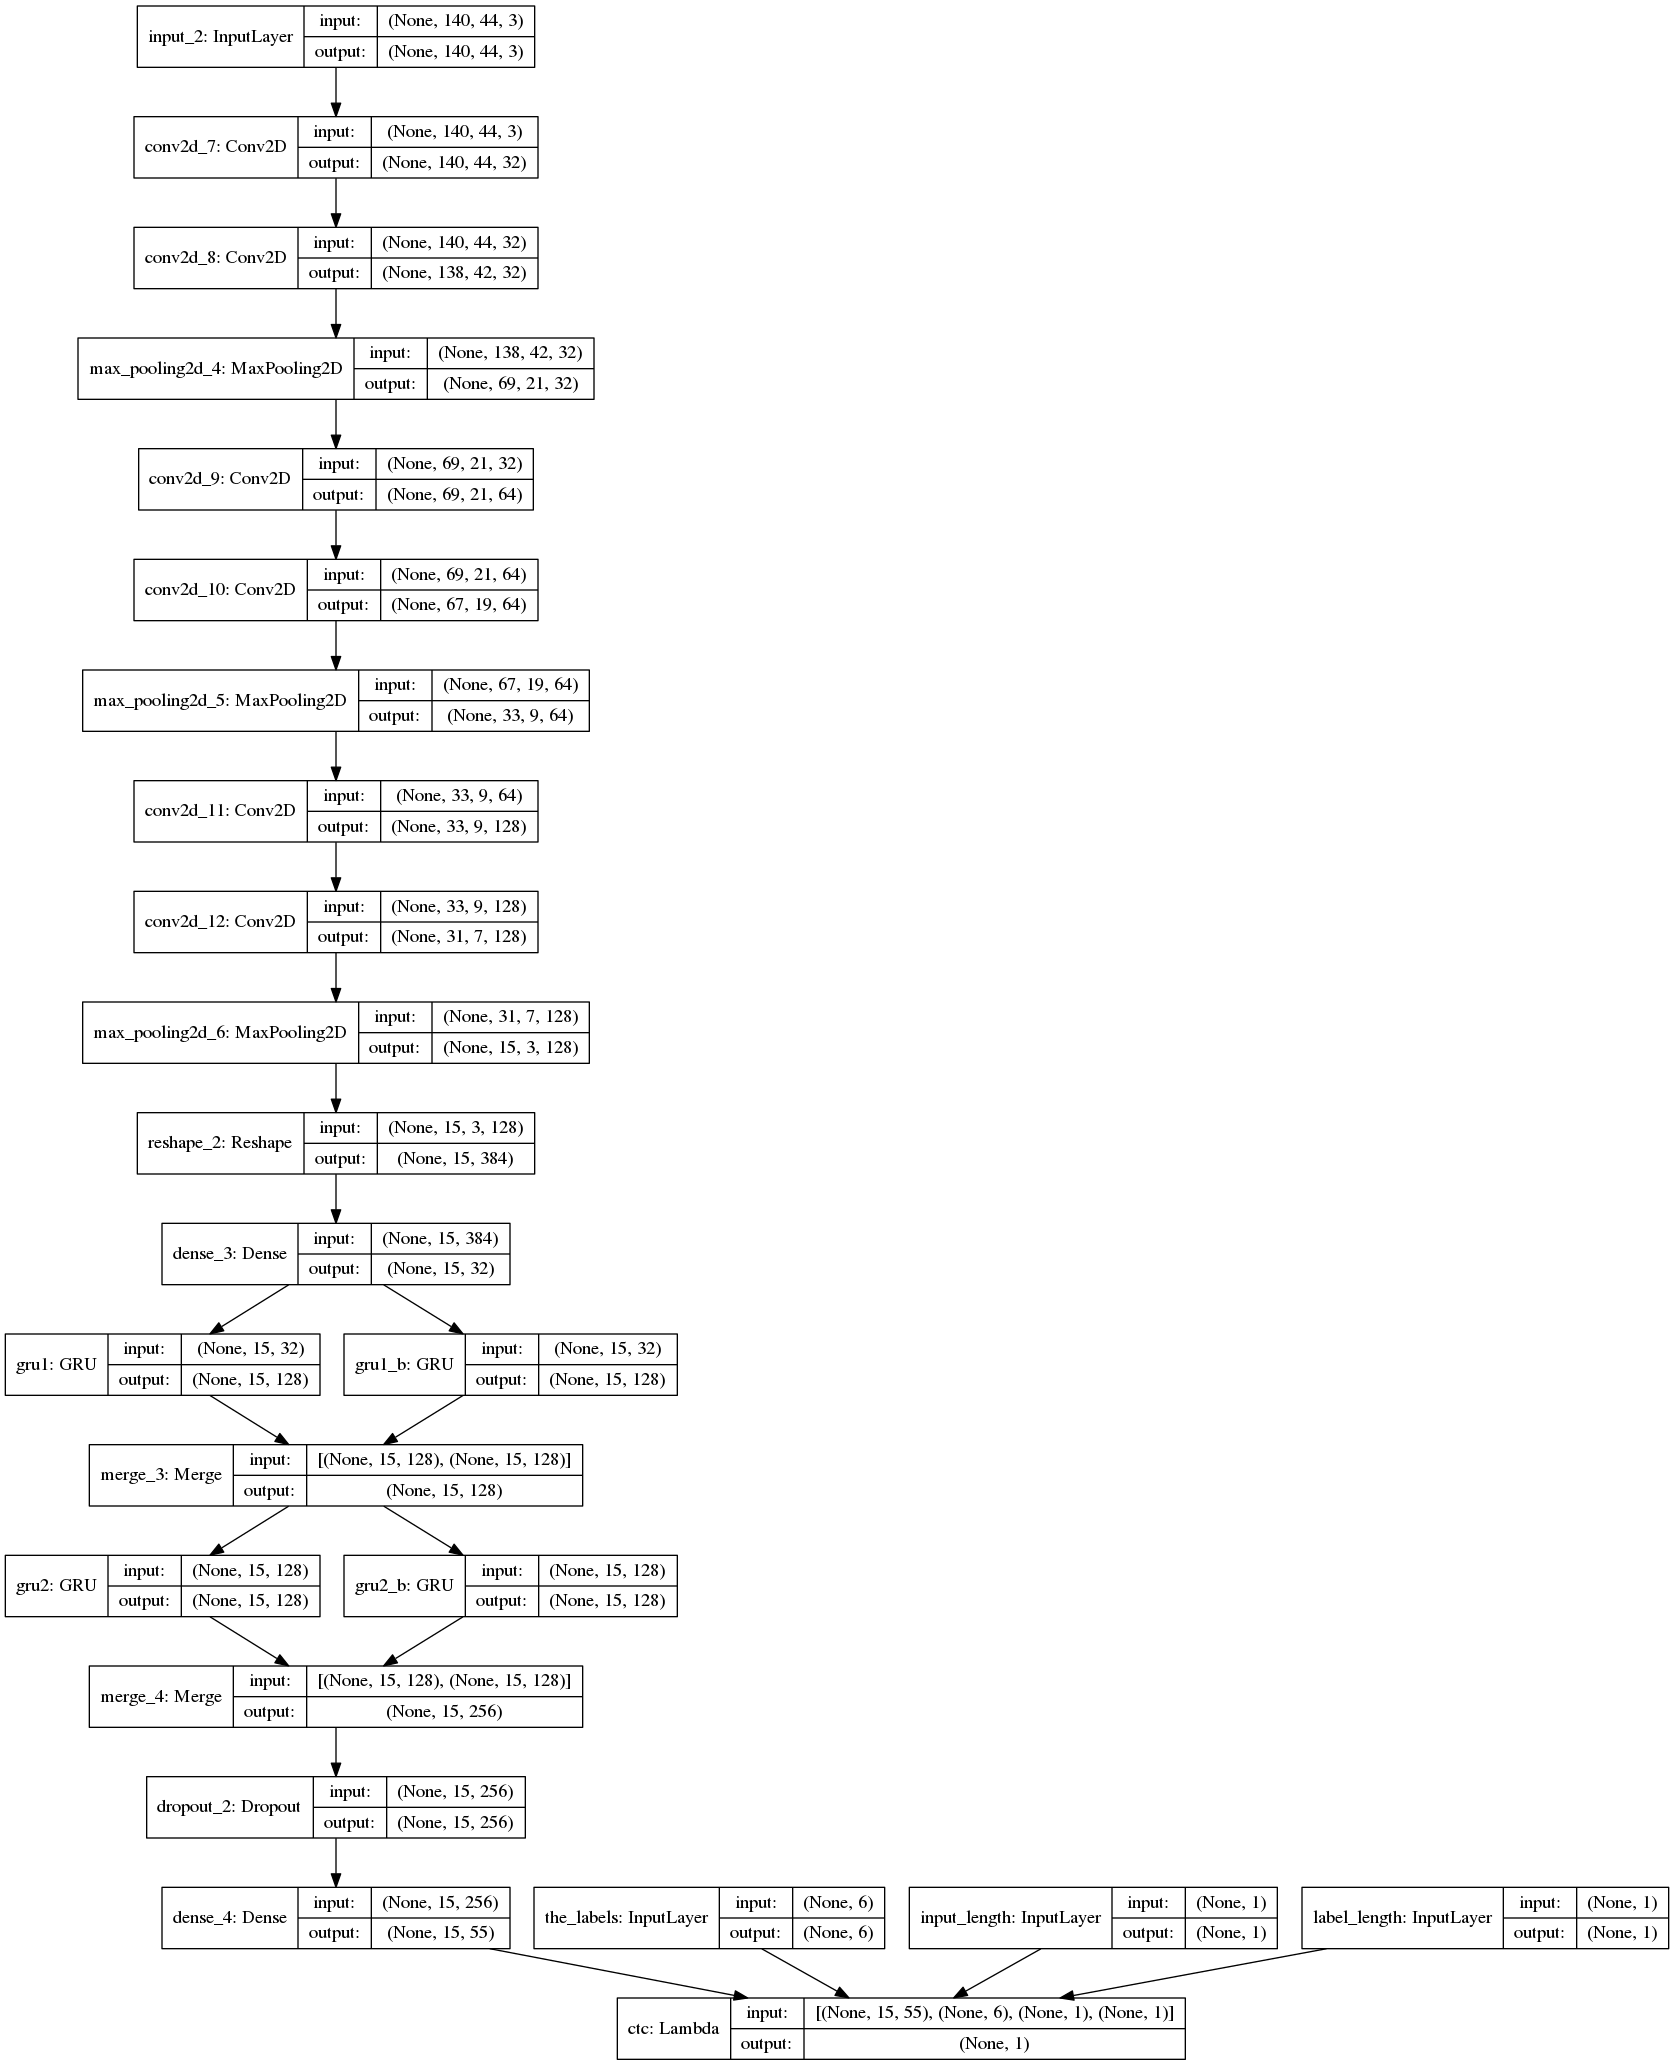

In [11]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="ctc_model_v0.1.png", show_shapes=True)
Image('ctc_model_v0.1.png')

# 测试生成器

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from generator import ctc_captcha_generator as gen

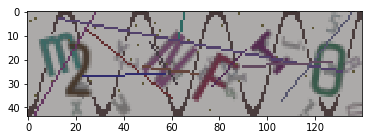

In [13]:
images = gen(width, height, 17)
[X_test, y_test, _, _], _  = next(images)
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.show()

# 建立任务

In [15]:
job = Job("3Q20LA3MXU3N8Y9NVJ7A1T5WNHL2IWQSNNJ5V9I5P7MRJ8LSC33EN2DT3EWYLCJA",
          "user1",
          "data_path",
          1,
          1,
          trainer,
          1000,
          10)

In [18]:
job.send_with_files('http://52.78.182.174:%d'%send_port, ['generator.py'])

# 等待Job结束

In [19]:
job.wait_completion()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1231: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [20]:
trained_model = job.get_trained_model()

In [21]:
trained_model.save('ctc_trained_model.h5')

# 结束

In [ ]:
sc.stop()